### HGT features in A. castellanii
**cmdoret, 20201009**

In this notebook, I compare the nucleotide composition and general features of A.castallanii genes with HGT candidates. I previously computed the following genome composition metrics in 1kb non-overlapping sliding windows:
* GC content $\frac{G+C}{A+C+G+T}$
* GC skew $\frac{G-C}{G+C}$
* AT skew $\frac{T-A}{T+A}$
* Shannon entropy $\sum_{i \in \left(A,C,G,T\right)}{P(i)*log(P(i))}$
* k-mer euclidean distance $\sqrt{\sum_{k \in kmers(ref)}{\left(P(ref[k]) - P(window[k])\right)^2}}$

I then intersected those windows with gene coordinates in the A. castellanii genome and for each gene, I computed the mean of those statistics (in case it overlaps multiple windows. Each gene also has two additional features: the number of exon (NEXON) and its length (LEN).

In [61]:
import umap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

First, I scale all features into z-scores so that they have comparable magnitudes (mean=0, stdev=1).

In [62]:
c3 = pd.read_csv('../../data/out/hgt/C3_windows_hgt.tsv', sep='\t')
neff = pd.read_csv('../../data/out/hgt/Neff_windows_hgt.tsv', sep='\t')
fields = ['LEN', 'NEXON', 'GC', 'GCSKEW', 'ATSKEW', 'ENTRO', '2MER', '3MER', '4MER']
neff['LEN'] = neff.end - neff.start
c3['LEN'] = c3.end - c3.start
neff.LEN = np.log10(neff.LEN)
neff.NEXON = np.log10(neff.NEXON)
c3.LEN = np.log10(c3.LEN)
c3.NEXON = np.log10(c3.NEXON)
neff.loc[:, fields] = neff.loc[:, fields].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
c3.loc[:, fields] = c3.loc[:, fields].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

I want to compare HGT and non-HGT gene. To get these labels, I retrieved all HGT ids from the original A. castellanii Neff genome paper and extracted the corresponding sequences in the annotations. Out of the 402 listed HGT ids, only 172 are in the annotations.

I then blasted those 172 genes against the proteomes of my 2 assemblies (Neff and C3 strains) and for each HGT, I recovered the best match if it had >95% identity. This gives me a list of 117 HGT in Neff and 43 in C3.

In [77]:
%%bash
echo "$(wc -l ../../data/input/misc/NEFF_v1_HGT.tsv | cut -d' ' -f1) HGT ID from Clarke et al."
echo "$(grep ">" ../../data/out/hgt/NEFF_v1_hgt_cds.fa | wc -l) found in the original assembly."
echo "$(wc -l ../../data/out/blast/hgt_v1_vs_Neff_filtered.blast | cut -d' ' -f1) Matches in the new Neff assembly"
echo "$(wc -l ../../data/out/blast/hgt_v1_vs_C3_filtered.blast | cut -d' ' -f1) Matches in the new C3 assembly"

402 HGT ID from Clarke et al.
172 found in the original assembly.
143 Matches in the new Neff assembly
72 Matches in the new C3 assembly


We can see that several features are correlated with each other. For example, k-mer profile divergence are similar for all 3 kmer length selected. Length and number of exons are also highly correlated.

Text(0.5, 1.0, 'Correlation between gene features in C3')

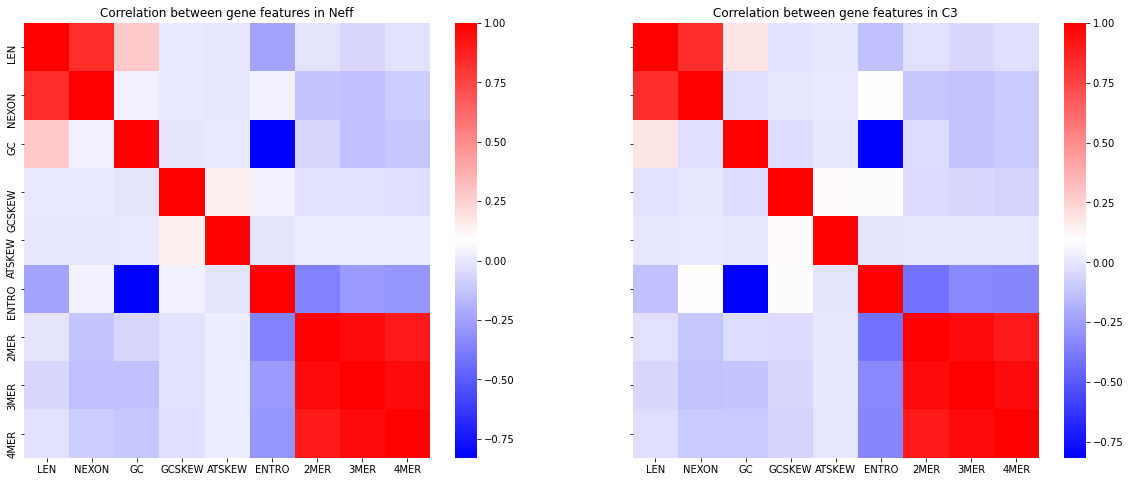

In [65]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 8))
sns.heatmap(neff.loc[:, fields].corr(), cmap='bwr', ax=axes[0])
axes[0].set_title("Correlation between gene features in Neff")
sns.heatmap(c3.loc[:, fields].corr(), cmap='bwr', ax=axes[1])
axes[1].set_title("Correlation between gene features in C3")

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


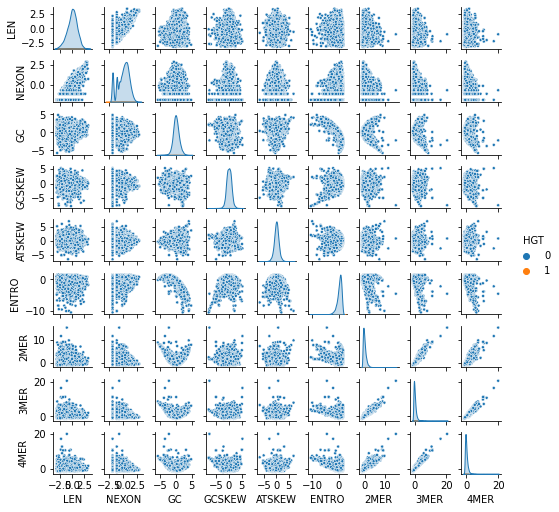

In [66]:
%matplotlib inline
sns.pairplot(c3.loc[:, fields+['HGT']], hue="HGT", markers='.', size=0.8)


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


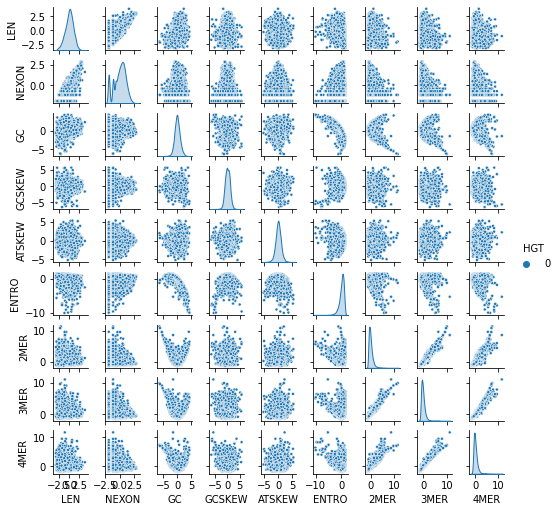

In [48]:
%matplotlib inline
sns.pairplot(neff.loc[:, fields+['HGT']], hue="HGT", markers='.', size=0.8)

Since several of those features are correlated to each other, I tried to remove that redundancy using PCA. HGT do not stand out in any particular way from the rest of the genome.

Text(0.5, 0.98, 'PCA of gene statistics in A. castellanii')

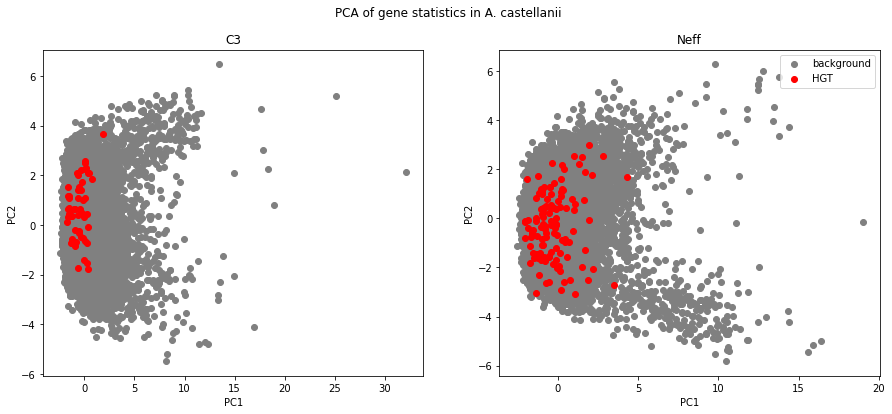

In [67]:
%matplotlib inline
pca_neff = PCA()
pcs_neff = pca_neff.fit_transform(neff.loc[:, fields])
neff['pc1'] = pcs_neff[:, 0]
neff['pc2'] = pcs_neff[:, 1]
pca_c3 = PCA()
pcs_c3 = pca_c3.fit_transform(c3.loc[:, fields])
c3['pc1'] = pcs_c3[:, 0]
c3['pc2'] = pcs_c3[:, 1]
fix, ax = plt.subplots(1, 2, figsize=(15, 6))
for i, df, strain in zip(range(2), [c3, neff], ['C3', 'Neff']):
    bg = df.loc[df.HGT==0, :]
    hgt = df.loc[df.HGT==1, :]
    ax[i].scatter(bg.pc1, bg.pc2, c='grey', label='background')
    ax[i].scatter(hgt.pc1, hgt.pc2, c='red', label='HGT')
    ax[i].set_title(strain)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
ax[1].legend()
plt.suptitle(f'PCA of gene statistics in A. castellanii')

In [68]:
import scipy.stats as ss
pval = ss.mannwhitneyu(c3.pc1[c3.HGT==1], c3.pc1[c3.HGT==0])[1]
print(f"HGT are not so different than C3 background in PC1 (p={pval:.2f})")

HGT are not so different than C3 background in PC1 (p=0.08)


In [69]:
pval = ss.mannwhitneyu(neff.pc1[neff.HGT==1], neff.pc1[neff.HGT==0])[1]
print(f"HGT are not different than Neff background in PC1 (p={pval:.2f})")

HGT are not different than Neff background in PC1 (p=0.14)


Text(0.5, 1.0, 'Comparison of gene features between HGT and background in Neff')

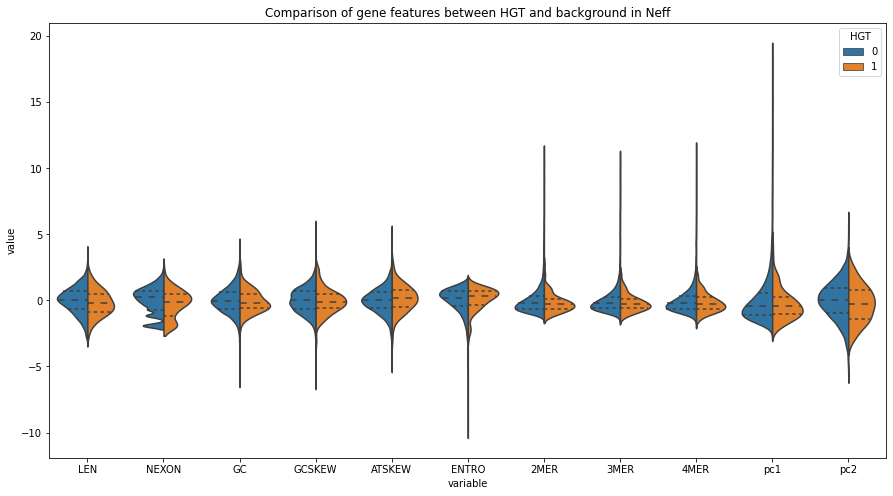

In [70]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
long_neff = pd.melt(neff.loc[:, fields + ['HGT', 'pc1', 'pc2']], id_vars=['HGT'], value_vars=fields+['pc1', 'pc2'])
sns.violinplot(data=long_neff, x='variable', y='value', split=True, hue='HGT', inner='quartiles', ax=ax)
plt.title("Comparison of gene features between HGT and background in Neff")

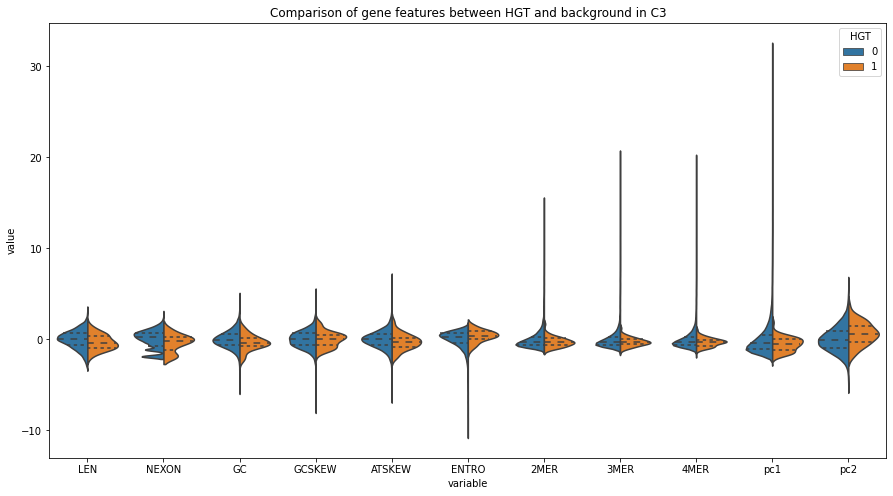

In [71]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pca_c3 = PCA()
pcs_c3 = pca_c3.fit_transform(c3.loc[:, fields])
c3['pc1'] = pcs_c3[:, 0]
c3['pc2'] = pcs_c3[:, 1]
long_c3 = pd.melt(c3.loc[:, fields + ['HGT', 'pc1', 'pc2']], id_vars=['HGT'], value_vars=fields+['pc1', 'pc2'])
sns.violinplot(data=long_c3, x='variable', y='value', split=True, hue='HGT', inner='quartiles', ax=ax)
plt.title("Comparison of gene features between HGT and background in C3")
plt.savefig('/home/cmatthey/pCloudDrive/reports_phd/20200617_acastellanii_ms/assets/hgt_windows/features_stats_c3.svg')

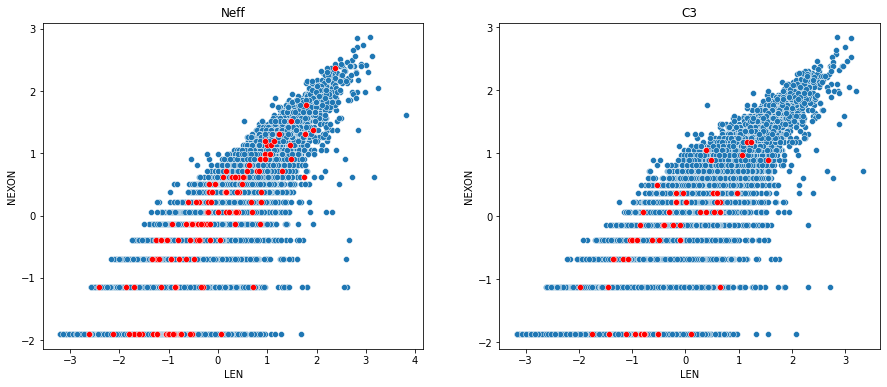

In [72]:
%matplotlib inline
neff['gene_len'] = neff.end - neff.start
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
for i, df, strain in zip(range(2), [neff, c3], ["Neff", "C3"]):
    sns.scatterplot(data=df.loc[df.HGT == 0], x="LEN", y="NEXON", ax=ax[i])
    sns.scatterplot(data=df.loc[df.HGT == 1], x="LEN", y="NEXON", color='red', ax=ax[i])
    ax[i].set_title(strain)


In [73]:
sx_bg_neff = sum(neff.loc[neff.HGT==0, "NEXON"] == neff.NEXON.min()) / len(neff.loc[neff.HGT==0, "NEXON"])
sx_ht_neff = sum(neff.loc[neff.HGT==1, "NEXON"] == neff.NEXON.min()) / len(neff.loc[neff.HGT==1, "NEXON"])
print(f"There are {100*sx_bg_neff:.2f}% single-exon genes in Neff, vs {100*sx_ht_neff:.2f}% for HGT candidates.")

There are 10.92% single-exon genes in Neff, vs 17.60% for HGT candidates.


In [74]:
sx_bg_c3 = sum(c3.loc[c3.HGT==0, "NEXON"] == c3.NEXON.min()) / len(c3.loc[c3.HGT==0, "NEXON"])
sx_ht_c3 = sum(c3.loc[c3.HGT==1, "NEXON"] == c3.NEXON.min()) / len(c3.loc[c3.HGT==1, "NEXON"])
print(f"There are {100*sx_bg_c3:.2f}% single-exon genes in C3, vs {100*sx_ht_c3:.2f}% for HGT candidates.")

There are 11.59% single-exon genes in C3, vs 20.75% for HGT candidates.


In [75]:
ss.ttest_ind(neff.loc[neff.HGT==0, 'NEXON'], neff.loc[neff.HGT==1, 'NEXON'])

Ttest_indResult(statistic=2.5692316820395003, pvalue=0.01020168119464719)

In [76]:
ss.ttest_ind(c3.loc[c3.HGT==0, 'NEXON'], c3.loc[c3.HGT==1, 'NEXON'])

Ttest_indResult(statistic=2.739276901495461, pvalue=0.006163905399471631)

In [81]:
for strain, df in zip(['C3', 'Neff'], [c3, neff]):
    for field in fields:
        res = ss.ttest_ind(df.loc[df.HGT==0, field], df.loc[df.HGT==1, field])[1]
        print(f'{strain}, {field}: pval={res:.2f}')

C3, LEN: pval=0.03
C3, NEXON: pval=0.01
C3, GC: pval=0.01
C3, GCSKEW: pval=0.92
C3, ATSKEW: pval=0.09
C3, ENTRO: pval=0.00
C3, 2MER: pval=0.06
C3, 3MER: pval=0.06
C3, 4MER: pval=0.04
Neff, LEN: pval=0.06
Neff, NEXON: pval=0.01
Neff, GC: pval=0.62
Neff, GCSKEW: pval=0.59
Neff, ATSKEW: pval=0.07
Neff, ENTRO: pval=0.19
Neff, 2MER: pval=0.04
Neff, 3MER: pval=0.05
Neff, 4MER: pval=0.06
